# Notebook to compare different runs varying coupling constants
## Gather Plaquette, polyakov loop and Acceptance 
Author: Venkitesh Ayyar (vayyar@bu.edu) \
May 4, 2023

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools
import yaml
import sys

In [3]:
import gvar as gv

In [4]:
# %matplotlib widget

In [5]:
%matplotlib notebook

In [6]:
sys.path.append('modules')
from modules_parse_hmc_Grid import *
from modules_measurement import *


$$ \chi_\mathcal{O} = L^3 \left[ \langle \mathcal{O}^2 \rangle - {(\langle \mathcal{O} \rangle )}^2 \right] = L^3 \langle (\mathcal{O} - \bar{\mathcal{O}})^2\rangle $$ 

$$ \kappa_\mathcal{O} = \frac{\langle \mathcal{O}^4 \rangle - 4 \langle \mathcal{O}^3 \rangle \langle \mathcal{O} \rangle +6 \langle \mathcal{O}^2 \rangle {\langle \mathcal{O} \rangle} ^2 - 3 {\langle \mathcal{O} \rangle}^4 }{\chi_\mathcal{O}^2} = \frac{ \langle \left( \mathcal{O-\bar{\mathcal{O}}} \right) ^4 \rangle }{\chi_\mathcal{O}^2}$$ 

In [7]:
def f_moments(y,L):
    ''' Compute susceptibility and Kurtosis for observables'''
    
    
    mode=2
    
    if mode==1: ## Using gvar for error propagation
        m=[gv.gvar(0,0) for i in range(5)]  # List to store moments
        m[0]=gv.gvar(1,1e-16) # zeroth moment is 1
        for i in range(1,5):
            m[i]=gv.dataset.avg_data(y**i)

        # Check moments obtained by gvar, with direct calculation
        n=[gv.gvar(0,0) for i in range(5)]  # List to store moments
        n[0]=gv.gvar(1,1e-16) # zeroth moment is 1
        for i in range(1,5):
            arr=y**i
            n[i]=gv.gvar(np.mean(arr),np.std(arr)/np.sqrt(arr.shape[0]))

        sus=(L**3)*(m[2]-(m[1]**2))
        if sus>1e-7: 
            kurt=(m[4] - 4* m[3] *m[1] + 6* m[2]* (m[1]**2) - 3* (m[1]**4))/(sus**2)
        else: kurt=gv.gvar(np.nan,np.nan)
        print("mode 1")
    
    elif mode==2: ## Propagating errors for high correlated variables doesn't work, so we use jackknife
        ### Compute arrays of moments
        m=[y**i for i in range(0,5)] # List to store powers of input

        ## Compute sus and kurt by jackknifing elements of this list
        arr=(y-np.mean(y))**2
        sus=(L**3) * f_jackknife(arr)
    #     print(sus)

        if sus>1e-7:
    #         arr=(m[4] - 4* m[3] *m[1] + 6* m[2]* (m[1]**2) - 3* (m[1]**4))/(sus**2)
            arr=((y-np.mean(y))**4)
            kurt= f_jackknife(arr) / (gv.mean(sus)**2)
        else: kurt=gv.gvar(np.nan,np.nan)
    
    return sus,kurt

In [12]:

Lx='*'
Lt='*'
data_dict={}
df_summary=pd.DataFrame([])

# top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_march14/dm_tests/runs/'
# top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram/'
# top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_4_cold_start/'
top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/'


fldr_list=glob.glob(top_dir+'run_Lx-%s_Lt-%s*'%(Lx,Lt))
# print(fldr_list)

equil=50
print("Equil",equil)

# fldr_list=['/usr/WS2/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-24_Lt-8_Ls-16_beta-10.6_mf-0.1']

for run_fldr in fldr_list: 
    print(run_fldr)
    # Read config file from folder
    input_dict=f_read_config(run_fldr+'/config.yaml')
    
    # Extract info from HMC output 
    flist=glob.glob(run_fldr+'/HSDM?.out')
    if len(flist)<1:    
        print("No file HSDM*.out in %s"%(run_fldr))
        continue
    
    
    # sort output file list sequentially
    flist=[file_name.split('HSDM')[0]+'HSDM%s.out'%(i+1) for i,file_name in enumerate(flist)]
    
    ## Sum results from successive runs
    for idx,fname in enumerate(flist):
#         print(fname)
        
        try : 
            df_a=f_parse_grid_data(fname)
#             display(a)
        except Exception as e:
            print(e,fname)
            continue
        
        if idx==0:
            df=df_a.copy()
        else : 
            df=f_merge_df_successive_runs(df,df_a)
    
    if equil>=df.shape[0]:
        print("Skipping %s, not enough configs"%(fname))
        continue
    
    key='beta-%s_mf-%s_Lx-%s_Lt-%s'%(input_dict['beta'],input_dict['mf'],input_dict['Lx'],input_dict['Lt'])
    
    if input_dict['F_action'] =='Mobius_dwf': ## Add Ls in label for DWF
        key+='_Ls-%s'%(input_dict['dwf_Ls'])
    
    count=1
    while(key in data_dict.keys()): # If duplicate key, add suffix
        print("Key exists",key,fname)
        count+=1
        key=key+'_%s'%(count)
        if count>10: break
        
    data_dict[key]=df
    
    # Get summary data
    dict2={}
    for key in ['beta','mf','Lx','Lt']:   dict2[key]=input_dict[key]
    if input_dict['F_action'] =='Mobius_dwf': ## Add Ls in label for DWF
        dict2['Ls']=input_dict['dwf_Ls']
    dict2=f_get_summary_data(df,input_dict['Lx'],dict2,equil)
        
    df_summary=pd.concat([df_summary,pd.DataFrame(dict2,index=[df_summary.shape[0]+1])])    
    
# Drop rows with no values
df_summary=df_summary.sort_values(by=['beta','mf']).reset_index(drop=True)
display(df_summary)


Equil 50
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-10.0_mf-0.1
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-10.2_mf-0.1
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-10.4_mf-0.1
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-10.6_mf-0.1
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-10.8_mf-0.1
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-11.0_mf-0.1
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-11.2_mf-0.1
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/

,beta,mf,Lx,Lt,Ls,plaq,sus_plaq,kurt_plaq,plaq_autocorr,polyakov,sus_poly,kurt_poly,poly_autocorr,traj_time,accept,num_conf
0,10.00,0.067,24,12,16,0.413095(21),0.000839(99),1.52(39)e-08,7,0.001731(78),0.0115(16),1.93(90)e-08,1,559.44(19),65.168539,138
1,10.00,0.100,16,8,16,0.413527(62),0.00189(31),2.5(1.0)e-07,4,0.00354(16),0.0129(22),2.7(1.4)e-07,1,141.403(22),78.125000,120
2,10.00,0.100,24,8,16,0.413385(40),0.00313(29),1.16(22)e-08,5,0.001657(76),0.0114(18),2.4(1.3)e-08,1,335.743(60),71.195652,144
3,10.00,0.100,24,12,16,0.413431(23),0.00118(14),1.69(41)e-08,5,0.001776(73),0.0119(14),1.72(63)e-08,1,477.13(10),71.782178,162
4,10.20,0.067,24,12,16,0.441692(32),0.00117(16),1.30(28)e-08,4,0.00156(12),0.0152(25),1.68(75)e-08,1,569.04(10),68.292683,83
5,10.20,0.100,16,8,16,0.442378(89),0.00384(45),1.55(31)e-07,6,0.00337(15),0.0108(12),1.44(29)e-07,1,142.857(26),88.607595,118
6,10.20,0.100,24,8,16,0.441855(42),0.00350(37),1.35(28)e-08,9,0.002031(94),0.0173(25),2.12(86)e-08,1,338.563(47),77.049180,143
7,10.40,0.067,24,12,16,0.51368(31),0.109(18),1.71(56)e-08,17,0.00192(12),0.0175(22),1.20(38)e-08,1,567.14(27),84.552846,83
8,10.40,0.100,16,8,16,0.51334(24),0.0303(20),9.3(1.3)e-08,31,0.00340(15),0.0118(17),2.16(91)e-07,1,134.351(93),92.215569,127
9,10.40,0.100,24,8,16,0.51388(13),0.0420(74),3.28(99)e-08,19,0.001943(76),0.0137(14),1.46(37)e-08,1,321.25(13),90.995261,171


In [13]:
df_sliced=df_summary[(df_summary.Lt.isin([8,12]))&(df_summary.mf==0.1)]
# df_sliced=df_summary[((df_summary.Lx==16)&(df_summary.Lt==8)&(df_summary.mf==0.1))|((df_summary.Lt==12)&(df_summary.mf==0.067))].copy()
df_sliced=df_sliced[((df_sliced.Lt==8)&(df_sliced.Lx==16))|((df_sliced.Lt==12)&(df_sliced.Lx==24))]
# df_sliced=df_summary.copy()
print(df_sliced.shape)

display(df_sliced)


(28, 16)


,beta,mf,Lx,Lt,Ls,plaq,sus_plaq,kurt_plaq,plaq_autocorr,polyakov,sus_poly,kurt_poly,poly_autocorr,traj_time,accept,num_conf
1,10.0,0.1,16,8,16,0.413527(62),0.00189(31),2.5(1.0)e-07,4,0.00354(16),0.0129(22),2.7(1.4)e-07,1,141.403(22),78.125000,120
3,10.0,0.1,24,12,16,0.413431(23),0.00118(14),1.69(41)e-08,5,0.001776(73),0.0119(14),1.72(63)e-08,1,477.13(10),71.782178,162
5,10.2,0.1,16,8,16,0.442378(89),0.00384(45),1.55(31)e-07,6,0.00337(15),0.0108(12),1.44(29)e-07,1,142.857(26),88.607595,118
8,10.4,0.1,16,8,16,0.51334(24),0.0303(20),9.3(1.3)e-08,31,0.00340(15),0.0118(17),2.16(91)e-07,1,134.351(93),92.215569,127
11,10.6,0.1,16,8,16,0.547096(46),0.00256(17),1.42(19)e-07,5,0.00445(13),0.0217(20),2.09(55)e-07,1,113.61(16),94.674556,298
13,10.6,0.1,24,12,16,0.547030(23),0.00091(10),1.32(23)e-08,3,0.001899(94),0.0152(22),1.84(57)e-08,1,403.16(49),84.756098,124
16,10.8,0.1,16,8,16,0.564431(32),0.00137(10),1.66(22)e-07,3,0.00567(17),0.0364(37),2.61(78)e-07,1,100.159(94),93.169399,326
18,10.9,0.1,16,8,16,0.571710(22),0.001553(74),1.62(16)e-07,4,0.01885(33),0.349(13),1.238(75)e-07,129,93.99(15),94.154229,764
20,11.0,0.1,16,8,16,0.578366(19),0.001510(67),1.76(19)e-07,4,0.02850(33),0.440(22),2.02(16)e-07,116,89.88(11),93.424926,979
22,11.0,0.1,24,12,16,0.578123(19),0.000764(97),1.84(64)e-08,3,0.002061(91),0.0182(21),1.63(43)e-08,1,331.08(45),87.878788,158


In [14]:
# data_dict.keys()

## Summary plots

In [15]:
# df_sliced=df_sliced[df_sliced.Lx==24]
mf_list   = np.sort(np.unique(df_sliced.mf.values))
beta_list = np.sort(np.unique(df_sliced.beta.values))
# Lt_list = np.sort(np.unique(df_sliced.Lt.values))

## Combining Lx and Lt into a label 
L_list=np.unique([str(i)+'_'+str(j) for i,j in zip(df_sliced.Lx.values, df_sliced.Lt.values)])
mf_list,beta_list,L_list

(array([0.1]),
 array([10. , 10.2, 10.4, 10.6, 10.8, 10.9, 11. , 11.1, 11.2, 11.3, 11.4,
        11.5, 11.6, 11.7, 11.8, 11.9, 12. , 12.5, 13. , 13.5, 14. ]),
 array(['16_8', '24_12'], dtype='<U5'))

### Plot Polyakov loop vs $\beta$ for different $m_f$

<IPython.core.display.Javascript object>


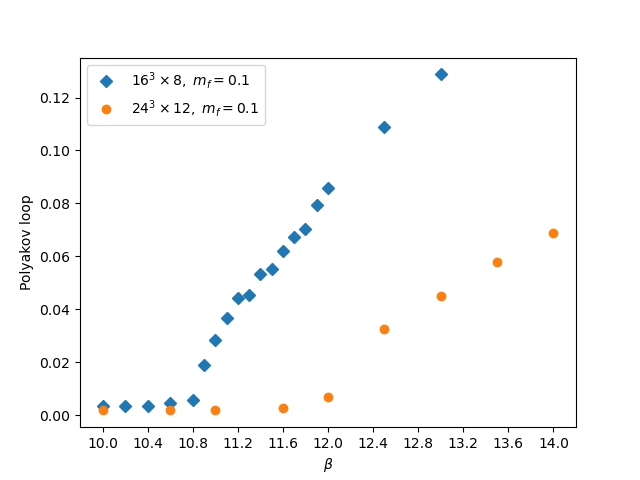

Text(0, 0.5, 'Polyakov loop')

In [16]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('Do*xd>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
    for mf in mf_list:
#         label='mf=%s_L=%s'%(mf,l)
        label=r'${%s}^3 \times %s ,\ m_f=%s$'%(l.split('_')[0],l.split('_')[1],mf)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)
        
    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.polyakov.values
    #     print(x,y)
#         plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        plt.plot(x,gv.mean(y),linestyle='',label=label,marker=marker)

plt.show()
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(min(beta_list),max(beta_list)+0.2,0.4))
plt.legend()
plt.ylabel('Polyakov loop',rotation='vertical')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
# plt.savefig('fig_output/Ploop_vs_beta.pdf')

### Plaquette vs beta

<IPython.core.display.Javascript object>


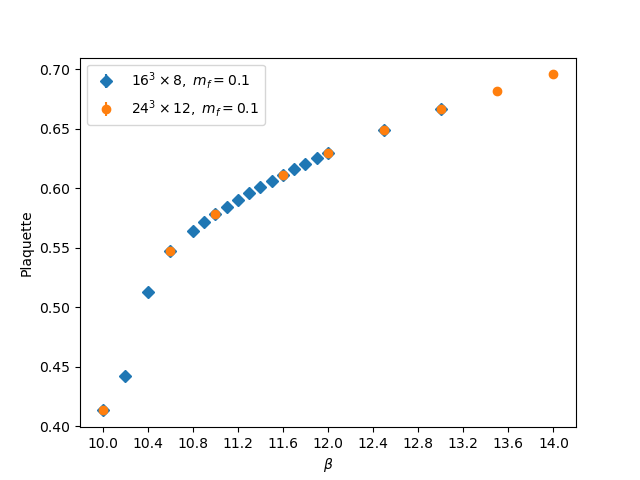

Text(0, 0.5, 'Plaquette')

In [17]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('Do*xd>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
    for mf in mf_list:
#         label='mf=%s_L=%s'%(mf,l)
        label=r'${%s}^3 \times %s ,\ m_f=%s$'%(l.split('_')[0],l.split('_')[1],mf)

        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.plaq.values
    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(min(beta_list),max(beta_list)+0.2,0.4))
plt.legend()
plt.ylabel('Plaquette',rotation='vertical')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
# plt.savefig('fig_output/Plaq_vs_beta.pdf')

### Plot Polyakov loop vs $m_f$ for different $\beta$

In [18]:
# plt.figure()

# for (l,marker) in zip(L_list,itertools.cycle('o*d>^sDHPdpx_')):
#     lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
#     df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
#     for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):
#         label='beta=%s_l=%s'%(beta,l)
#         df1=df[df.beta==beta].sort_values(by=['mf'])
#     #     display(df1)

#     #     if df1.shape[0]>1:
#         x=df1.mf.values
#         y=df1.polyakov.values
#     #     print(x,y)
#         plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

# plt.xlabel(r'$m_f$')
# # plt.xticks(mf_list)
# # plt.xlim(-0.5,2.0)
# plt.legend(loc='best')
# plt.ylabel('Polyakov loop',rotation='vertical')
# # plt.savefig('fig_output/Ploop_vs_mf.pdf')

### Plot Susceptibility

<IPython.core.display.Javascript object>


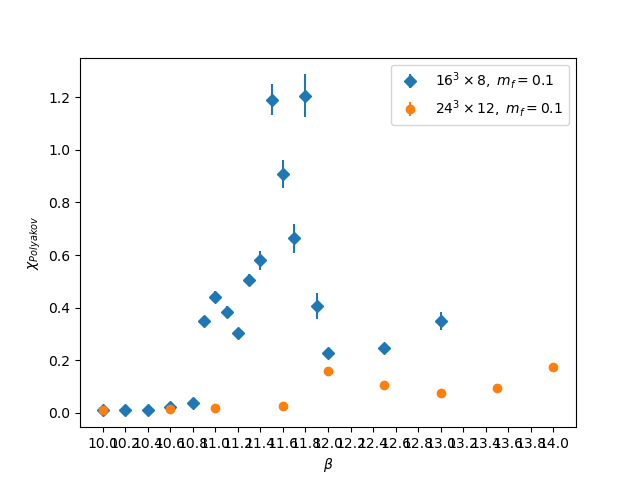

Text(0, 0.5, '$\\chi_{Polyakov}$')

In [19]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('Do*xd>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
    for mf in mf_list:
#         label='mf_%s_L=%s'%(mf,l)
        label=r'${%s}^3 \times %s ,\ m_f=%s$'%(l.split('_')[0],l.split('_')[1],mf)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
#         y=df1.sus_plaq.values
        y=df1.sus_poly.values

    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(min(beta_list),max(beta_list)+0.2,0.2))
plt.legend()
plt.ylabel('$\chi_{Polyakov}$',rotation='vertical')
# plt.savefig('fig_output/chi_poly_vs_beta.pdf')

<IPython.core.display.Javascript object>


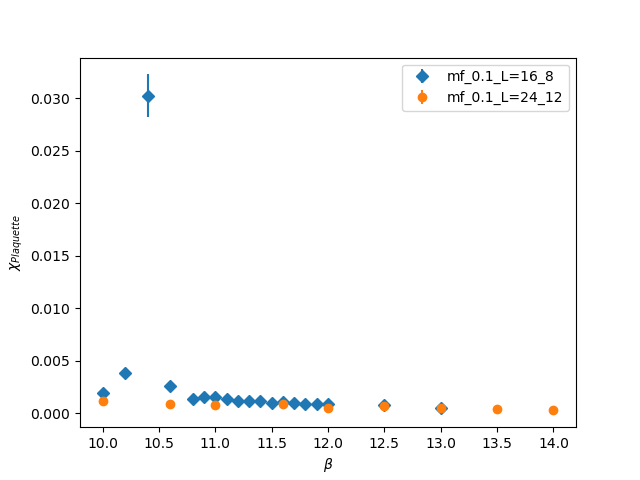

Text(0, 0.5, '$\\chi_{Plaquette}$')

In [20]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('Do*xd>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
    for mf in mf_list:
        label='mf_%s_L=%s'%(mf,l)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.sus_plaq.values

    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('$\chi_{Plaquette}$',rotation='vertical')
# plt.savefig('chi_plaq_vs_beta.pdf')

<IPython.core.display.Javascript object>


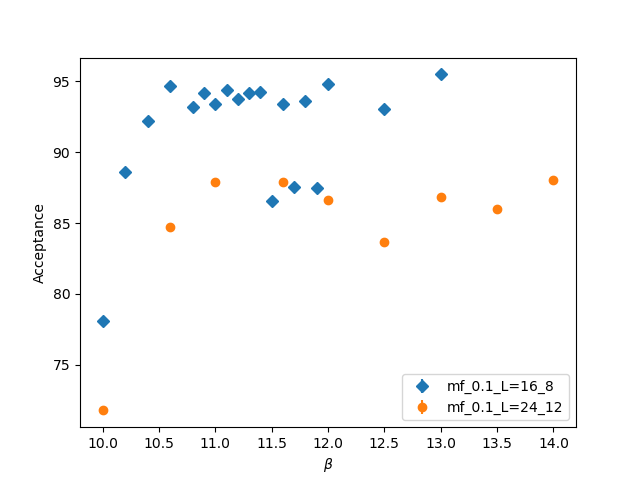

Text(0, 0.5, 'Acceptance')

In [21]:
# Plot acceptance rate 

# plt.figure()

# for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):

#     label='beta_%s'%(beta)
#     df1=df_sliced[df_sliced.beta==beta].sort_values(by=['mf'])
# #     display(df1)
    
# #     if df1.shape[0]>1:
#     x=df1.mf.values
#     y=df1.accept.values
# #     print(x,y)
#     plt.plot(x,y,linestyle='',label=label,marker=marker)
# #     plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

# plt.xlabel(r'$m_f$')
# # plt.xticks(mf_list)
# # plt.xlim(-0.5,2.0)
# plt.legend(loc='best')
# plt.ylabel('Acceptance',rotation='vertical')
# # plt.savefig('Acceptance_vs_mf.pdf')


plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('Do*xd>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
    for mf in mf_list:
        label='mf_%s_L=%s'%(mf,l)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
#         y=df1.sus_plaq.values
        y=df1.accept.values

    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('Acceptance',rotation='vertical')
# plt.savefig('Acceptance_vs_beta.pdf')


<IPython.core.display.Javascript object>


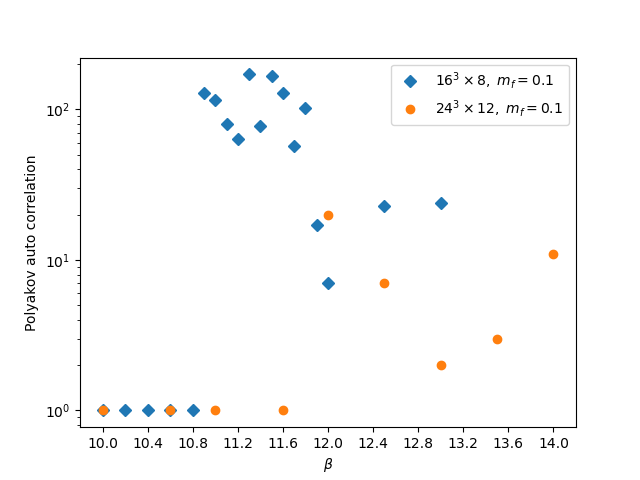

In [22]:
# Autocorrelation

plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('Do*xd>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
    for mf in mf_list:
#         label='mf=%s_L=%s'%(mf,l)
        label=r'${%s}^3 \times %s ,\ m_f=%s$'%(l.split('_')[0],l.split('_')[1],mf)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)
        
    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.poly_autocorr.values
#         y=df1.plaq_autocorr.values
    #     print(x,y)
#         plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        plt.plot(x,gv.mean(y),linestyle='',label=label,marker=marker)

plt.show()
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(min(beta_list),max(beta_list)+0.2,0.4))
plt.legend()
plt.ylabel('Polyakov auto correlation',rotation='vertical')
plt.yscale('log')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
# plt.savefig('fig_output/Ploop_vs_beta.pdf')

## Individual plots

In [ ]:
data_dict.keys()

In [ ]:

def f_plot_specific_runs(data_dict,column,keys_list):
    ''' Plot behavior of quantity in MC time
    col = Plaquette, Polyakov, Traj_time, Accept, Plaq_epoch'''
    
    assert len(keys_list)>0 ,"Shortened list has 0 elements" 
    
    plt.figure()

    for i,marker in zip(keys_list,itertools.cycle('>^*sDHPdpx_')):

        df=data_dict[i]
        label=i
        print(label)
        x=df.iter.values
        if column=='Polyakov':
            y=np.abs(df[column].values)
        else:
            y=df[column].values

        plt.plot(x,y,linestyle='',label=label, marker=marker)

    plt.legend(loc='best')
    plt.ylabel(column)
    plt.xlabel('Trajectory')
    plt.show()
    
    
# beta_list=[9.0,10.0,10.2,10.4,10.5,10.6,10.8]
beta_list=[11.0,11.2,11.6,12.0,13.0][:]
mf_list=[0.1]
## Gather dict keys with given beta and mf values
Ls=16
Lt=8
keys_list=['beta-%s_mf-%s_Lx-16_Lt-%s_Ls-%s'%(b,m,Lt,Ls) for m in mf_list for b in beta_list]

f_plot_specific_runs(data_dict,'Plaquette',keys_list)
plt.savefig('Plaq_details.pdf')

# f_plot_specific_runs(dict_list,'Traj_time',keys_list)

f_plot_specific_runs(data_dict,'Polyakov',keys_list)
plt.savefig('Polyakov_details.pdf')


In [ ]:
f_plot_specific_runs(data_dict,'Accept',keys_list)


### Plot Polyakov loop

In [ ]:
# fig=plt.figure()

# for i in dict_list:
#     df=i['df']
#     label=i['beta']+'_'+i['mf']
# #     print(label)
    
    
#     x=df.iter.values
#     y=df.Polyakov.values
#     fig.add_subplot(2,1,1)

#     plt.plot(x,y.real,marker='o',linestyle='',label=label)
#     plt.ylabel('Real Polyakov loop')

#     fig.add_subplot(2,1,2)

#     plt.plot(x,y.imag,marker='o',linestyle='',label=label)
    
# plt.legend(loc='best')
# plt.ylabel('Imag Polyakov loop')
# plt.show()


In [ ]:
data_dict.keys()

In [ ]:
keys_list

In [ ]:
keys_list=['beta-%s_mf-%s_Lx-16_Lt-8_Ls-16'%(b,m) for m in mf_list for b in beta_list]


fig=plt.figure()

for i,marker in zip(keys_list,itertools.cycle('>^*sDHPdpx_')):
    df=data_dict[i]
    label=i
    print(label)

    x=df.iter.values
    y=df.Polyakov.values

    y1=y.real
    y2=y.imag

    plt.scatter(y1,y2,label=label,marker=marker)
    
plt.legend(loc='best')
plt.xlabel('Real Polyakov loop')
plt.ylabel('Imag Polyakov loop')
plt.title("Scatter plot")
plt.show()

In [ ]:
# Histogram
beta=10.8
mf=0.1
key='beta-%s_mf-%s_Lx-16_Lt-8_Ls-16'%(beta,mf)

df=data_dict[key]

fig=plt.figure()
x=df.iter.values[:210]
y=np.abs(df.Polyakov.values[:210])

# hist,bins=np.histogram(y,bins=10)
# plt.bar(np.linspace(0,0.3,10),hist)
# plt.stairs(hist)

plt.hist(y,bins=50,color='b')

plt.title("Polyakov loop Histogram for beta: %s"%(beta))
plt.savefig('ploop_histogram.pdf')

In [ ]:
df